Jupyter notebook for the Kaggle Titanic survival prediction competition.
https://www.kaggle.com/competitions/titanic/overview

Preprocesses and cleans the data.
Tests a few sklearn models with default parameters.
Formats the test data for submission to Kaggle.

In [1]:
import pandas as pd

#read in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#take a look at it
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#get some info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
#get some basic numerical variable statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#get some basic categorical variable statistics
train.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


We can make a number of useful observations for pre-processing just from these basic data explorations. <br>
- PassengerID can be dropped, it is simply an increasing integer identifier and won't be useful for predictions (we will keep test passengerID so we can write the appropriate kaggle output though). 
- Survived looks good as is. It is a binary 0 or 1 with no missing values and no outlier values. 
- Pclass also looks good as is. It has 3 values as int 1, 2, or 3 and has no missing values. 
- Name doesn't make sense as a predictor of survival and given that every name is a unique string there is no good way to include it, we will drop name. 
- Sex is binary male or female, has no missing values, and only 2 unique values so appears to not have any issues. We will just need to encode it as binary 0 or 1 int. 
- Age has 177 out of 891 missing values so we will probably want to impute those missing values. Imputing as the mean is probably the most straightforward here. The existing values all look okay as they have an appropriate range of 0.42 to 80 years. 
- Sibsp, the number of siblings and spouses, looks good as is. There are no missing values and the range is appropriate so there are no outliers. 
- The same is true for parch, number of parents and childen. 
- Ticket appears to fall in the same camp as Name. A ticket number doesn't make a lot of sense as a predictor of survival and given there are 681 unique tickets it would be difficult to encode. I think it is okay to drop it. 
- Fare looks good as is. While Cabin seems like it could be increasing predictor of survival, given more than half of values are missing imputing those is probably not going to be very accurate so drop Cabin. 
- Embarked looks pretty clean but there are two missing values that we can encode as the most frequent and then we will need to encode the 3 embark values. 
- We don't need to check for duplicates because every Name is unique

In summary, drop passengerID, Name, Ticket, and Cabin. Impute missing Age values and impute 2 missing Embarked values. Encode Sex and Embarked. 

In [5]:
#before making the changes we should also check the test dataset just in case

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
test.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


Everything looks the same as the train dataset except we don't need to impute anything for Embarked but we will need to impute one value for the Fare. We can use the mean fare for that. 

In [8]:
#make the same changes to both train and test but first need to save test passengerID before removing column from test
test_PassengerID = test['PassengerId']

#drop the specified columns
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)



In [9]:
#impute missing age values using the total combined mean of train and test data
combined = pd.concat([train['Age'], test['Age']])

age_mean = combined.mean(skipna = True)

train['Age'].fillna(age_mean, inplace = True)
test['Age'].fillna(age_mean, inplace = True)

#impute missing Embarked values in train dataset. Most frequent Embarked was 'S' 
train['Embarked'].fillna('S', inplace = True)


#impute missing Fare value in test dataset with the Fare mean across both train and test
combined_fare = pd.concat([train["Fare"], test['Fare']])
fare_mean = combined_fare.mean(skipna = True)

test['Fare'].fillna(fare_mean, inplace = True)


#encode the sex with 0 for male and 1 for female

train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

#encode Emabarked
#OneHotEncoding may be best here because this variable isn't binary but I'm going to start with label 
#encoding and see how it does

train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})


In [10]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


This looks pretty good to me. The last thing I want to do before training a model is take a quick look at the data. I want to look for any trends we should be aware of or any other information about the data that may affect model accuracy/performance interpretation. <br>

I will look at a correlation matrix, pair plots, and the frequency of the independent variable. 

In [11]:
#correlation matrix
train.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,0.543351,-0.070323,-0.035322,0.081629,0.257307,0.106811
Pclass,-0.338481,1.000000,-0.131900,-0.330367,0.083081,0.018443,-0.549500,0.045702
Sex,0.543351,-0.131900,1.000000,-0.084461,0.114631,0.245489,0.182333,0.116569
Age,-0.070323,-0.330367,-0.084461,1.000000,-0.232515,-0.179882,0.091002,0.009244
SibSp,-0.035322,0.083081,0.114631,-0.232515,1.000000,0.414838,0.159651,-0.059961
Parch,0.081629,0.018443,0.245489,-0.179882,0.414838,1.000000,0.216225,-0.078665
Fare,0.257307,-0.549500,0.182333,0.091002,0.159651,0.216225,1.000000,0.062142
Embarked,0.106811,0.045702,0.116569,0.009244,-0.059961,-0.078665,0.062142,1.000000


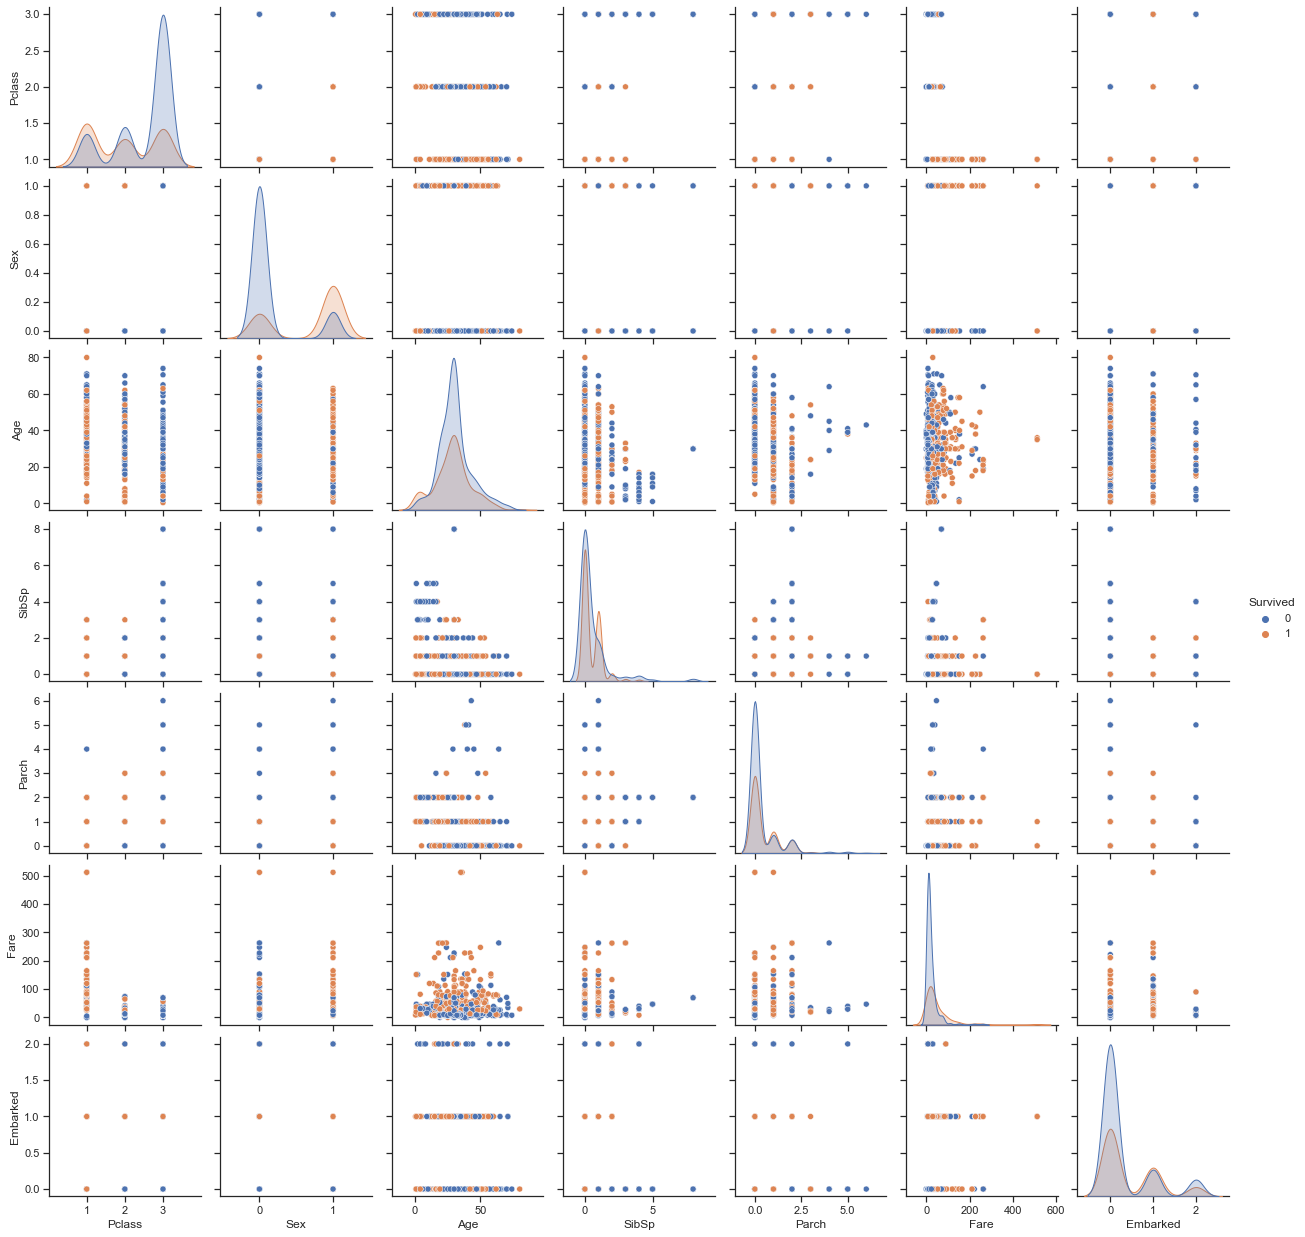

In [12]:
#pairplots
import seaborn as sns; sns.set(style='ticks', color_codes=True)

sns.pairplot(train, hue='Survived')

<AxesSubplot:ylabel='Survived'>

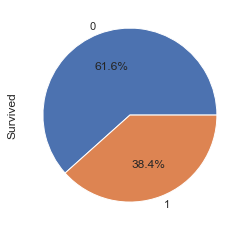

In [13]:
#independent variable frequency

train['Survived'].value_counts().plot.pie(autopct='%1.1f%%')

Observations: <br>

Sex appears like it could be our strongest predictive variable. Pclass is also solid with a negative correlation and Fare has a solid positive correlation. This makes sense as Pclass and Fare are themselves understandably correlated with each other. <br>

There are fewer survivors than not survivors in the training data but I think the frequency of each is close enough that we don't need to worry about it when setting train/test splits or considering accuracy. <br>

I will test a few of the common sklearn models with default parameters. I will randomly generate 80/20 train/test splits 25 times, train the models, predict with the models, and calculate the accuracy and mean accuracy of all 25 runs. Whichever model is highest accuracy I will use for Kaggle submission. 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

dt_acc = []
rf_acc = []
nb_acc = []
svm_acc = []


y = train['Survived']
X = train.drop('Survived', axis = 1)

for i in range(25) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    nb = GaussianNB()
    svm = svm_model = SVC()

    dt.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    nb.fit(X_train, y_train)
    svm.fit(X_train, y_train)

    y_pred = dt.predict(X_test)
    dt_acc.append(accuracy_score(y_pred, y_test))

    y_pred = rf.predict(X_test)
    rf_acc.append(accuracy_score(y_pred, y_test))

    y_pred = nb.predict(X_test)
    nb_acc.append(accuracy_score(y_pred, y_test))

    y_pred = svm.predict(X_test)
    svm_acc.append(accuracy_score(y_pred, y_test))

print(np.mean(dt_acc))
print(np.mean(rf_acc))
print(np.mean(nb_acc))
print(np.mean(svm_acc))


0.7767597765363129
0.8
0.7865921787709498
0.693854748603352


In [15]:
#Looks like random forest is performing best
#train with all of the train data

rf = RandomForestClassifier()
rf.fit(X, y)

#predict with the test data
y_pred = rf.predict(test)

In [16]:
#generate the data for Kaggle submission
#y_pred is an array of survival 0's and 1's so we can use it directly with the saved PassengerIDs to create a new df

submission = pd.DataFrame({
    'PassengerId' : test_PassengerID,
    'Survived' : y_pred
})
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [17]:
#write the dataframe to a csv to submit to Kaggle
submission.to_csv('submission.csv', index = False)